In [1]:
# General Imports
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import os

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Warnings
import warnings
warnings.filterwarnings("ignore")

# Building Model
from keras.utils import plot_model
from tensorflow.keras import models
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import legacy


# Training Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

# Model Evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

# Data Processing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import load_img

In [2]:
classes=[]
filename='brain-tumor-mri-dataset'
for sub_folder in os.listdir(os.path.join(filename,'Training')):
    classes.append(sub_folder)
print(classes)

['glioma', 'meningioma', 'notumor', 'pituitary']


In [3]:
train_path='brain-tumor-mri-dataset/Training/'
test_path='brain-tumor-mri-dataset/Testing/'

In [4]:
img_list=[]
label_list=[]
for label in classes:
    for img_file in os.listdir(train_path+label):
        img_list.append(train_path+label+'/'+img_file)
        label_list.append(label)

In [5]:
train_data = pd.DataFrame({'Image':img_list,'Label':label_list})
train_data

,Image,Label
0,brain-tumor-mri-dataset/Training/glioma/Tr-glT...,glioma
1,brain-tumor-mri-dataset/Training/glioma/Tr-glT...,glioma
2,brain-tumor-mri-dataset/Training/glioma/Tr-glT...,glioma
3,brain-tumor-mri-dataset/Training/glioma/Tr-glT...,glioma
4,brain-tumor-mri-dataset/Training/glioma/Tr-glT...,glioma
...,...,...
5707,brain-tumor-mri-dataset/Training/pituitary/Tr-...,pituitary
5708,brain-tumor-mri-dataset/Training/pituitary/Tr-...,pituitary
5709,brain-tumor-mri-dataset/Training/pituitary/Tr-...,pituitary
5710,brain-tumor-mri-dataset/Training/pituitary/Tr-...,pituitary


In [6]:
img_list=[]
label_list=[]
for label in classes:
    for img_file in os.listdir(test_path+label):
        img_list.append(test_path+label+'/'+img_file)
        label_list.append(label)

In [7]:
test_data = pd.DataFrame({'Image':img_list,'Label':label_list})
test_data

,Image,Label
0,brain-tumor-mri-dataset/Testing/glioma/Te-glTr...,glioma
1,brain-tumor-mri-dataset/Testing/glioma/Te-glTr...,glioma
2,brain-tumor-mri-dataset/Testing/glioma/Te-glTr...,glioma
3,brain-tumor-mri-dataset/Testing/glioma/Te-glTr...,glioma
4,brain-tumor-mri-dataset/Testing/glioma/Te-glTr...,glioma
...,...,...
1306,brain-tumor-mri-dataset/Testing/pituitary/Te-p...,pituitary
1307,brain-tumor-mri-dataset/Testing/pituitary/Te-p...,pituitary
1308,brain-tumor-mri-dataset/Testing/pituitary/Te-p...,pituitary
1309,brain-tumor-mri-dataset/Testing/pituitary/Te-p...,pituitary


In [8]:
def Plot_Classes(BASE_URL, Rows=2, Columns=5):


  plt.figure(figsize = (25, 8))

  image_count = 1

  for directory in os.listdir(BASE_URL):

      if directory[0] != '.':

          Max_Random = len(os.listdir(os.path.join(BASE_URL,directory)))

          Random_Number = np.random.randint(0, Max_Random)

          for i, file in enumerate(os.listdir(BASE_URL + directory)):

              if i == Random_Number:

                  fig = plt.subplot(Rows, Columns, image_count)
                  image_count += 1

                  image = plt.imread(BASE_URL + directory + '/' + file)
                  plt.imshow(image, cmap='gray')

                  plt.title(directory)

                  break

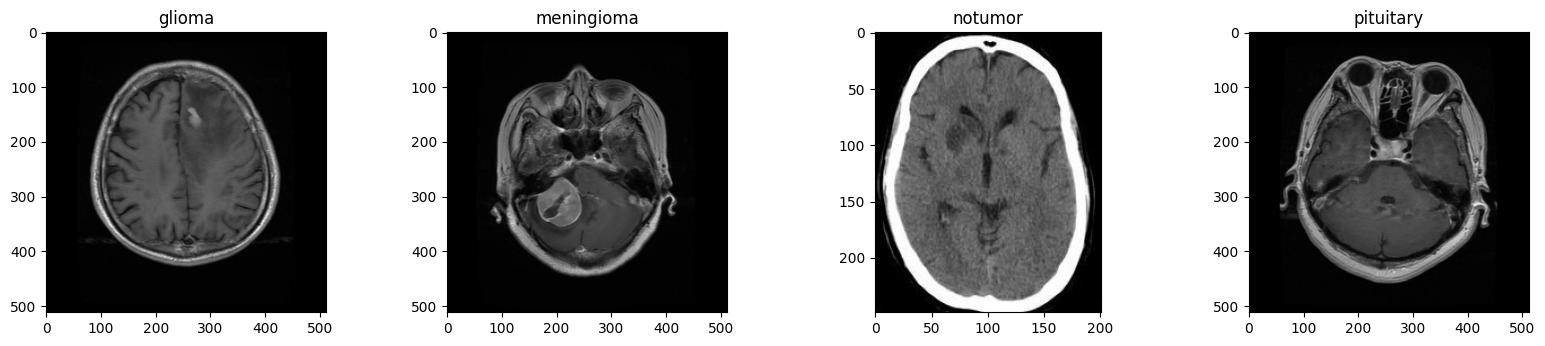

In [9]:
Plot_Classes(train_path)


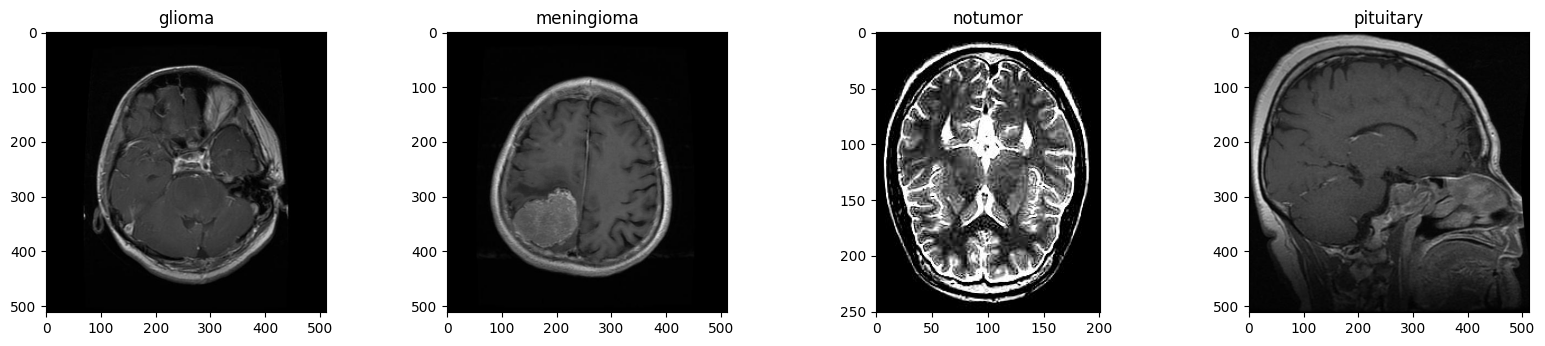

In [10]:
Plot_Classes(test_path)

In [11]:
train_data['Label'].value_counts()


Label
notumor       1595
pituitary     1457
meningioma    1339
glioma        1321
Name: count, dtype: int64

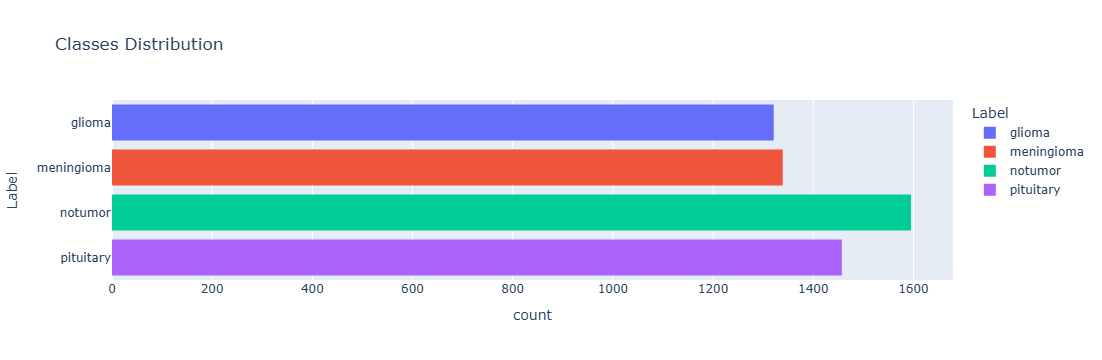

In [12]:
px.histogram(train_data, y="Label", color="Label", title="Classes Distribution")

In [13]:
test_data['Label'].value_counts()

Label
notumor       405
meningioma    306
glioma        300
pituitary     300
Name: count, dtype: int64

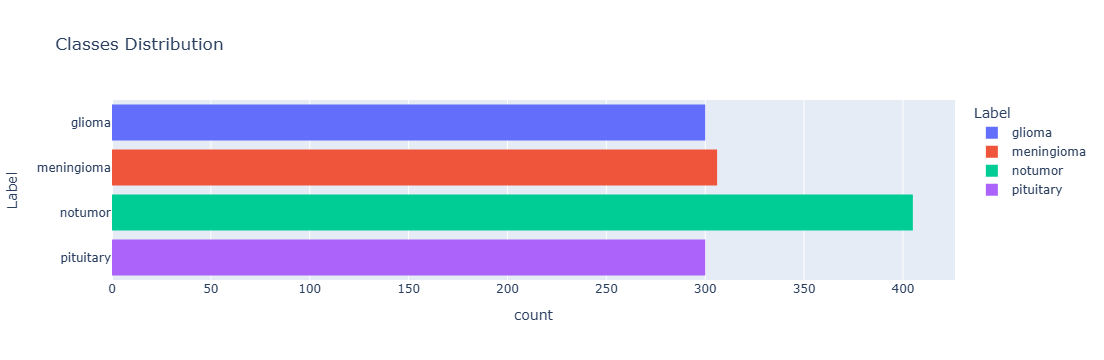

In [14]:
px.histogram(test_data, y="Label", color="Label", title="Classes Distribution")

In [15]:
# Image size
image_size = (150, 150)

# Training batch size
batch_size = 32

In [17]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.15, 
                                   rotation_range=10,
                                   brightness_range=(0.85, 1.15),
                                   width_shift_range=0.002,
                                   height_shift_range=0.002,
                                   shear_range=12.5,
                                   zoom_range=0,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   fill_mode="nearest")

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.15)

# Creating training data generator
train_generator = train_datagen.flow_from_directory(train_path,
                                                    target_size=image_size,
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    subset='training',  
                                                    seed=0)

# Creating validation data generator
val_generator = val_datagen.flow_from_directory(train_path,
                                                target_size=image_size,
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                subset='validation', 
                                                seed=0)

# No augmentation of the test data, just rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# applying the generator to testing data with constant seed
test_generator = test_datagen.flow_from_directory(test_path,
                                                  target_size=image_size,
                                                  batch_size=batch_size,
                                                  class_mode="categorical",
                                                  shuffle=False,
                                                  seed=0)

Found 4857 images belonging to 4 classes.
Found 855 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


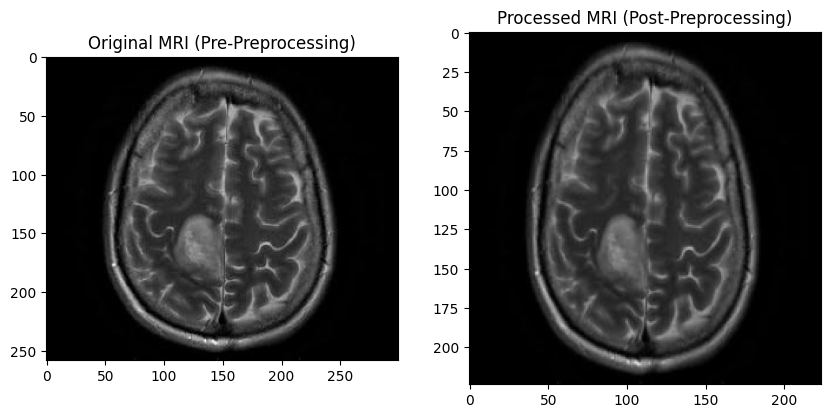

In [18]:
import cv2
# Load a sample MRI image (replace with your path)
original_img = cv2.imread("brain-tumor-mri-dataset\Training\meningioma\Tr-me_0188.jpg", cv2.IMREAD_GRAYSCALE)  # Reads as grayscale

# Preprocessing steps
resized_img = cv2.resize(original_img, (224, 224))  # Resize
normalized_img = resized_img / 255.0  # Normalize
rgb_img = np.stack([normalized_img]*3, axis=-1)  # Convert to 3-channel

# Display images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original MRI (Pre-Preprocessing)")
plt.imshow(original_img, cmap="gray")
plt.axis("on")

plt.subplot(1, 2, 2)
plt.title("Processed MRI (Post-Preprocessing)")
plt.imshow(rgb_img)  # VGG16-ready RGB format
plt.axis("on")
plt.show()

In [19]:
def show_ImageDataGenerator(ImageDataGenerator, num_samples=5, figsize=(12, 12), save=False):
    """
    Function to viusalize how the ImageDataGenerator augments the data
    """

    # Generate augmented samples
    # Use __next__() instead of next()
    augmented_samples = train_generator.__next__()

    # Extract images from the batch
    images = augmented_samples[0][:num_samples]

    # Display the augmented images
    fig, axes = plt.subplots(1, num_samples, figsize=figsize)

    for i, ax in enumerate(axes):
        ax.imshow(images[i])
        ax.axis('off')

    plt.tight_layout()

    if save:
        plt.savefig('show_ImageDataGenerator.pdf')

    plt.show()

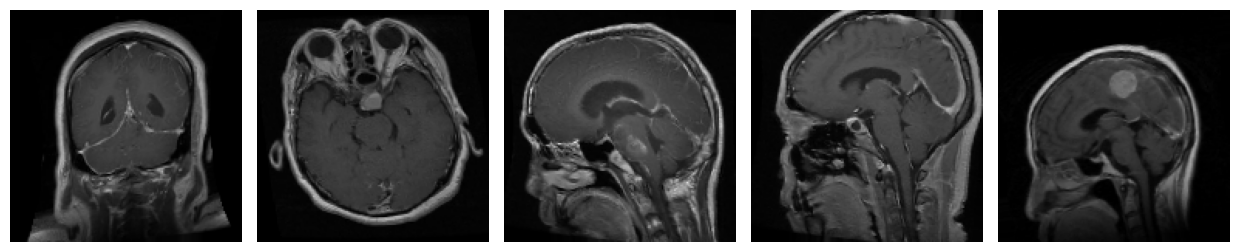

In [20]:
show_ImageDataGenerator(train_datagen, num_samples=5, figsize=(12.5, 8), save=False)

In [21]:
# Image shape: height, width, RBG
image_shape = (image_size[0], image_size[1], 3)


print(f'Image shape: {image_shape}')
print(f'Batch size: {batch_size}')
print(f'Number of Train batches: {len(train_generator)}')
print(f'Number of Validation batches: {len(val_generator)}')
print(f'Number of Testing batches: {len(test_generator)}')

Image shape: (150, 150, 3)
Batch size: 32
Number of Train batches: 152
Number of Validation batches: 27
Number of Testing batches: 41


In [22]:
Classes_Map = train_generator.class_indices

num_classes = len(Classes_Map)

print("Number of Classes:", num_classes)
Classes_Map

Number of Classes: 4


{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [23]:
def plot_curves(history):

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(1, len(loss) + 1)

  plt.figure(figsize=(15,5))
  plt.style.use('ggplot')


  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, 'bo-' , label = "TrainL oss")
  plt.plot(epochs, val_loss, 'o-' , color='orange', label = "Val Loss")
  plt.title("Loss")
  plt.xlabel("epochs")
  plt.legend()


  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, 'bo-' , label = "Train Acc")
  plt.plot(epochs, val_accuracy, 'o-' , color='orange' , label = "Val Acc")
  plt.title("Accuracy")
  plt.xlabel("epochs")
  plt.legend()

  plt.style.use('default')

In [24]:
def CM(model, test_generator, categories):
    """
    Function to return the confusion matrix of a given CNN model.
    """
    from sklearn.metrics import confusion_matrix
    # Predictions on test dataset
    predictions = model.predict(test_generator)
    predicted_categories = np.argmax(predictions, axis=1)
    true_categories = test_generator.classes

    # Create a confusion matrix
    confusion_matrix_array = confusion_matrix(true_categories, predicted_categories)
    print(f"Classification Report for {model}:")
    print(classification_report(true_categories, predicted_categories, target_names=categories))

    return confusion_matrix_array


def calculate_metrics(confusion_matrix, categories):
    """
    Function to calculate important metrics for multi-classification problems.
    """
    # Calculating 4 different metrics
    precision = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=0)
    recall = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=1)
    f1_score = 2 * (precision * recall) / (precision + recall)
    accuracy = np.sum(np.diag(confusion_matrix)) / np.sum(confusion_matrix)

    # Printing the results based on each category
    for i, category in enumerate(categories):
        print(f"Class: {category.title()}")
        print(f"Precision: {precision[i]:.3f}")
        print(f"Recall: {recall[i]:.3f}")
        print(f"F1-Score: {f1_score[i]:.3f}\n")

    # Showing the total accuracy of the model
    print(f"\nAccuracy: {accuracy:.3f}")

In [25]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


base_model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


for layer in base_model_vgg.layers[:-10]:
    layer.trainable = False

for layer in base_model_vgg.layers[-10:]:
    layer.trainable = True

# Add custom classification head
x = base_model_vgg.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)  

model_vgg = Model(inputs=base_model_vgg.input, outputs=output)

model_vgg.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

model_vgg.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 150, 150, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 75, 75, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 18, 18, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 9, 9, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         262,6

 Total params: 14,979,396 (57.14 MB)

 Trainable params: 13,833,988 (52.77 MB)

 Non-trainable params: 1,145,408 (4.37 MB)

In [31]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, ReduceLROnPlateau

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True,
    verbose=1
)

checkpoint_h5 = ModelCheckpoint(
    "best_vgg16_model.h5",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

checkpoint_keras = ModelCheckpoint(
    "best_vgg16_model.keras",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)


csv_logger = CSVLogger(
    'vgg16_training_log.csv',
    append=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=3,
    min_lr=1e-6,
    verbose=1
)


In [32]:
vgg_history = model_vgg.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[
        early_stopping,
        checkpoint_h5,
        checkpoint_keras,
        csv_logger,
        reduce_lr
    ]
)



Epoch 1/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9089 - loss: 0.2466
Epoch 1: val_loss improved from inf to 0.31036, saving model to best_vgg16_model.h5



Epoch 1: val_loss improved from inf to 0.31036, saving model to best_vgg16_model.keras
152/152 ━━━━━━━━━━━━━━━━━━━━ 219s 1s/step - accuracy: 0.9089 - loss: 0.2464 - val_accuracy: 0.8994 - val_loss: 0.3104 - learning_rate: 1.0000e-04
Epoch 2/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9409 - loss: 0.1573
Epoch 2: val_loss improved from 0.31036 to 0.18987, saving model to best_vgg16_model.h5



Epoch 2: val_loss improved from 0.31036 to 0.18987, saving model to best_vgg16_model.keras
152/152 ━━━━━━━━━━━━━━━━━━━━ 220s 1s/step - accuracy: 0.9410 - loss: 0.1573 - val_accuracy: 0.9450 - val_loss: 0.1899 - learning_rate: 1.0000e-04
Epoch 3/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9574 - loss: 0.1139
Epoch 3: val_loss did not improve from 0.18987

Epoch 3: val_loss did not improve from 0.18987
152/152 ━━━━━━━━━━━━━━━━━━━━ 220s 1s/step - accuracy: 0.9575 - loss: 0.1139 - val_accuracy: 0.9322 - val_loss: 0.2296 - learning_rate: 1.0000e-04
Epoch 4/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9693 - loss: 0.0914
Epoch 4: val_loss did not improve from 0.18987

Epoch 4: val_loss did not improve from 0.18987
152/152 ━━━━━━━━━━━━━━━━━━━━ 219s 1s/step - accuracy: 0.9693 - loss: 0.0913 - val_accuracy: 0.9404 - val_loss: 0.2247 - learning_rate: 1.0000e-04
Epoch 5/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9675 - loss: 0.0911
Epoch 5: val_loss did not


Epoch 6: val_loss improved from 0.18987 to 0.15636, saving model to best_vgg16_model.keras
152/152 ━━━━━━━━━━━━━━━━━━━━ 229s 2s/step - accuracy: 0.9875 - loss: 0.0383 - val_accuracy: 0.9637 - val_loss: 0.1564 - learning_rate: 3.0000e-05
Epoch 7/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9964 - loss: 0.0147
Epoch 7: val_loss did not improve from 0.15636

Epoch 7: val_loss did not improve from 0.15636
152/152 ━━━━━━━━━━━━━━━━━━━━ 223s 1s/step - accuracy: 0.9964 - loss: 0.0147 - val_accuracy: 0.9591 - val_loss: 0.1955 - learning_rate: 3.0000e-05
Epoch 8/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9953 - loss: 0.0156
Epoch 8: val_loss did not improve from 0.15636

Epoch 8: val_loss did not improve from 0.15636
152/152 ━━━━━━━━━━━━━━━━━━━━ 220s 1s/step - accuracy: 0.9953 - loss: 0.0156 - val_accuracy: 0.9579 - val_loss: 0.2169 - learning_rate: 3.0000e-05
Epoch 9/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9981 - loss: 0.0097
Epoch 9: val_loss did not

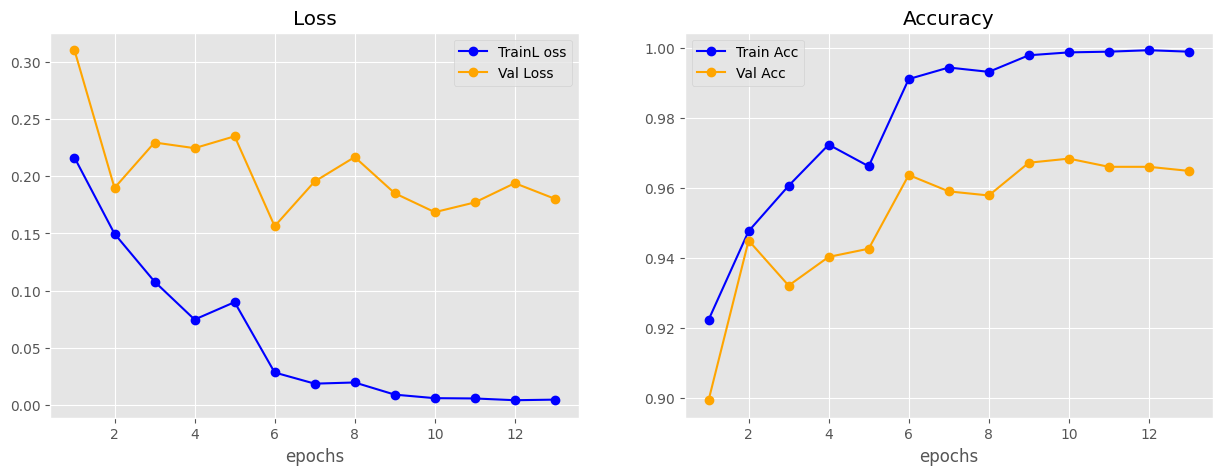

In [33]:

plot_curves(vgg_history)

In [34]:
loss, accuracy = model_vgg.evaluate(test_generator)
print(f"Test Loss: {loss:0.5f}")
print(f"Test Accuracy: {accuracy:0.5f}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 31s 755ms/step - accuracy: 0.9732 - loss: 0.0879
Test Loss: 0.05118
Test Accuracy: 0.98246


41/41 ━━━━━━━━━━━━━━━━━━━━ 29s 705ms/step
Classification Report for <Functional name=functional, built=True>:
              precision    recall  f1-score   support

      glioma       1.00      0.96      0.98       300
  meningioma       0.96      0.98      0.97       306
     notumor       0.98      1.00      0.99       405
   pituitary       0.99      0.99      0.99       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311



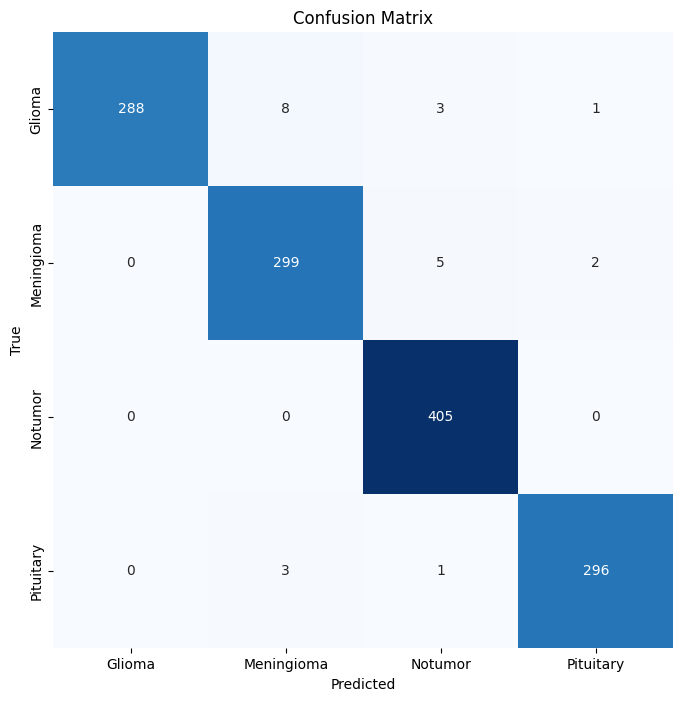

In [35]:
# Plotting confusion matrix
confusion_matrix = CM(model=model_vgg, test_generator=test_generator, categories=classes)

plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(4) + 0.5,
           labels=[name.title() for name in classes], ha='center')
plt.yticks(ticks=np.arange(4) + 0.5,
           labels=[name.title() for name in classes], va='center')
plt.show()